In [52]:
# Import the NetworkX package
import networkx as nx

import torch
print("PyTorch has version {}".format(torch.__version__))

import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

import torch.nn.functional as F

from torch_geometric.datasets import KarateClub

%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

from sklearn.manifold import TSNE

from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


PyTorch has version 1.13.1+cu117


In [53]:
# Helper function for visualization.

# Visualization function for NX graph or PyTorch tensor
def visualize(G, h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                         node_color=color, cmap="Set2")
    plt.show()

## Dataset

In [54]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of nodes: 34
Number of features: 34
Number of classes: 4


In [55]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [56]:
print(data.x.shape)
data.x

torch.Size([34, 34])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [57]:
print(data.y.shape)
data.y

torch.Size([34])


tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [58]:
print(data.edge_index.shape)
data.edge_index

torch.Size([2, 156])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [59]:
data.edge_index.t()

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [60]:
print(data.train_mask.shape)
data.train_mask

torch.Size([34])


tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [61]:
# The adjacency matrix can be inferred from the edge_index with a utility function.

from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


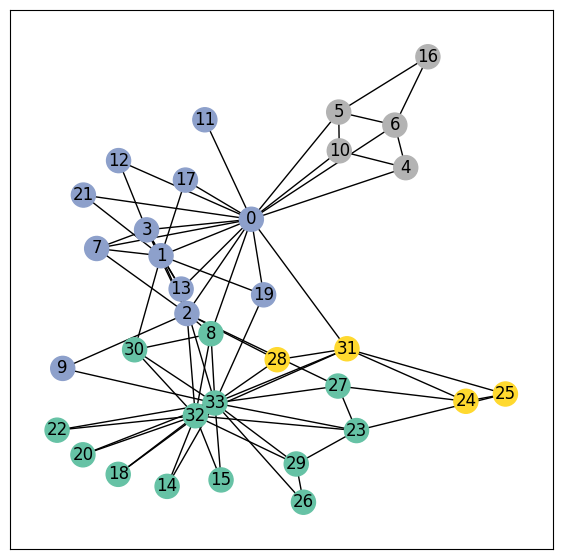

In [62]:
G = to_networkx(data, to_undirected=True)
visualize(G, None, color=data.y)

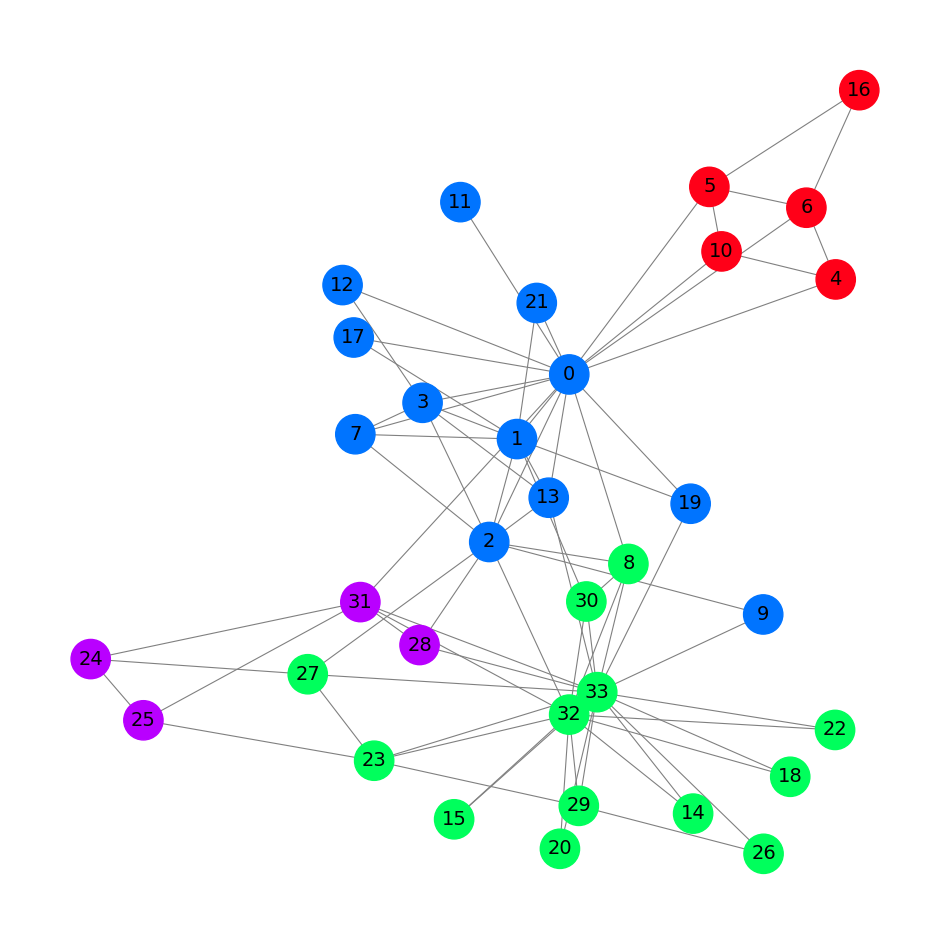

In [63]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [64]:
t = torch.tensor([1, 2, 3])

print(torch.sigmoid(t))
print(torch.tanh(t))
print(torch.relu(t))
# print(F.log_softmax(t, dim=-1))

tensor([0.7311, 0.8808, 0.9526])
tensor([0.7616, 0.9640, 0.9951])
tensor([1, 2, 3])


In [65]:
import math

def sigmoid (x):
    return 1 / (1 + math.e ** - x)

def tanh(x):
    return (math.e ** x - math.e ** -x) / (math.e ** x + math.e ** -x)

def relu(x):
    if x < 0:
        return 0
    return x


print(sigmoid(1))
print(tanh(1))
print(relu(1))

0.7310585786300049
0.7615941559557649
1


In [163]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data, epochs):
    """Train a model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)  # Define optimizer.

    model.train()
    for epoch in range(epochs):
        # Training
        optimizer.zero_grad()  # Clear gradients.
        out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
        # loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss = criterion(out, data.y)
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        # Validation
        """ val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask]) """

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch + 1:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}%')
            """ print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%') """
    return model

def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [182]:
def plot_embedding_3d(h):
    if torch.is_tensor(h):
        embed = h.detach().cpu().numpy()
    else:
        embed = h

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.patch.set_alpha(0)
    plt.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
            s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

    plt.show()

In [ ]:
def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1), h

### Parameters

In [161]:
epochs = 200
dim_in = dataset.num_features
dim_h = 3
dim_out = dataset.num_classes

## Graph Convolutional Network (GCN)

In [169]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.classifier = Linear(dim_h, dim_out)

    def forward(self, x, edge_index):
        # Node ebeddings
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

gcn = GCN(dim_in, dim_h, dim_out)
print(gcn)

GCN(
  (conv1): GCNConv(34, 3)
  (conv2): GCNConv(3, 3)
  (conv3): GCNConv(3, 3)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)


Embedding shape: [34, 3]


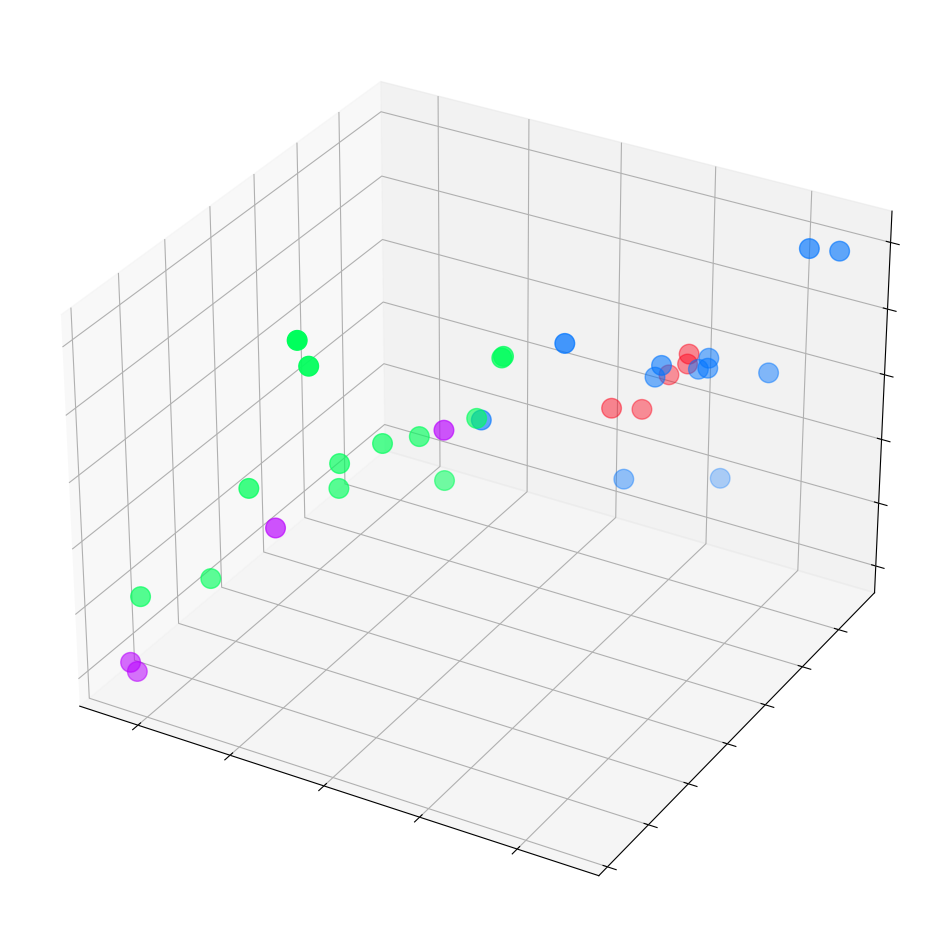

In [170]:
# Get embeddings
_, h = gcn(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

In [171]:
# Train
train(gcn, data, epochs)

# Test
# acc = test(gcn, data)
# print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   1 | Train Loss: 1.415 | Train Acc:  25.00%
Epoch  11 | Train Loss: 1.216 | Train Acc:  25.00%
Epoch  21 | Train Loss: 0.966 | Train Acc:  50.00%
Epoch  31 | Train Loss: 0.726 | Train Acc:  25.00%
Epoch  41 | Train Loss: 0.632 | Train Acc:  50.00%
Epoch  51 | Train Loss: 0.507 | Train Acc:  50.00%
Epoch  61 | Train Loss: 0.396 | Train Acc:  75.00%
Epoch  71 | Train Loss: 0.318 | Train Acc:  75.00%
Epoch  81 | Train Loss: 0.261 | Train Acc:  75.00%
Epoch  91 | Train Loss: 0.181 | Train Acc: 100.00%
Epoch 101 | Train Loss: 0.113 | Train Acc: 100.00%
Epoch 111 | Train Loss: 0.070 | Train Acc: 100.00%
Epoch 121 | Train Loss: 0.046 | Train Acc: 100.00%
Epoch 131 | Train Loss: 0.033 | Train Acc: 100.00%
Epoch 141 | Train Loss: 0.026 | Train Acc: 100.00%
Epoch 151 | Train Loss: 0.021 | Train Acc: 100.00%
Epoch 161 | Train Loss: 0.018 | Train Acc: 100.00%
Epoch 171 | Train Loss: 0.016 | Train Acc: 100.00%
Epoch 181 | Train Loss: 0.014 | Train Acc: 100.00%
Epoch 191 | Train Loss: 0.013 |

GCN(
  (conv1): GCNConv(34, 3)
  (conv2): GCNConv(3, 3)
  (conv3): GCNConv(3, 3)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)

Embedding shape: [34, 3]


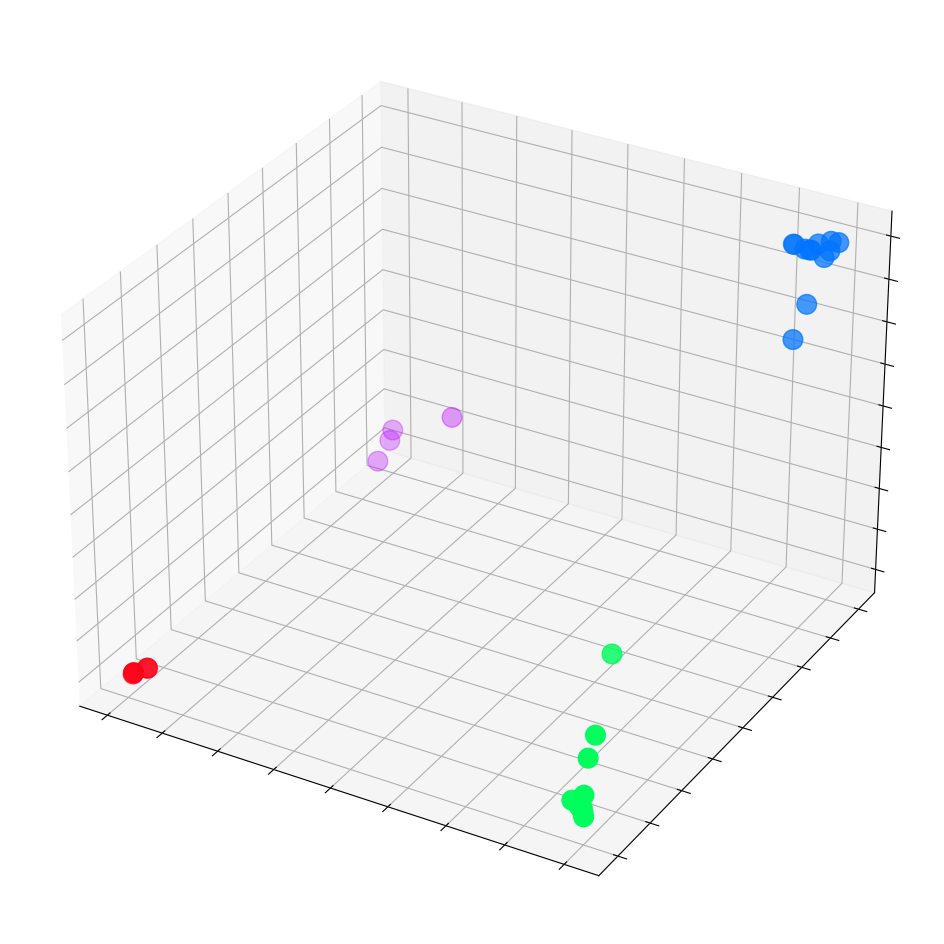

In [172]:
# Get embeddings
_, h = gcn(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

#### Others

In [ ]:
""" import matplotlib.animation as animation

def animate(i):
    ax.clear()
    h = embeddings[i]
    h = h.detach().numpy()
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
    ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

fig = plt.figure(figsize=(7, 7))
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(epochs), repeat=False)
# plt.show() """

In [ ]:
""" from IPython import display

video = anim.to_html5_video()
html_code = display.HTML(video)
display.display(html_code) """

In [73]:
# gif_writer = animation.PillowWriter(fps=20)
# anim.save('embeddings.gif', writer=gif_writer)

In [75]:
""" %%capture
import numpy as np

from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2], s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f}', fontsize=18, pad=40)

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=False)
html = HTML(anim.to_html5_video()) """

# display.display(html)

## Graph Attention Network (GAT)

In [178]:
class GAT(torch.nn.Module):
	"""Graph Attention Network"""
	def __init__(self, dim_in, dim_h, dim_out, heads=1):
		super().__init__()
		self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
		self.gat2 = GATv2Conv(dim_h, dim_h, heads=1)
		self.gat3 = GATv2Conv(dim_h, dim_h, heads=1)
		self.classifier = Linear(dim_h, dim_out)

	def forward(self, x, edge_index):
		# Node ebeddings
		h = self.gat1(x, edge_index)
		h = h.tanh()
		h = self.gat2(h, edge_index)
		h = h.tanh()
		h = self.gat3(h, edge_index)
		h = h.tanh()  # Final GNN embedding space.
		
		# Apply a final (linear) classifier.
		out = self.classifier(h)

		return out, h

gat = GAT(dim_in, dim_h, dim_out)
print(gat)

GAT(
  (gat1): GATv2Conv(34, 3, heads=1)
  (gat2): GATv2Conv(3, 3, heads=1)
  (gat3): GATv2Conv(3, 3, heads=1)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)


Embedding shape: [34, 3]


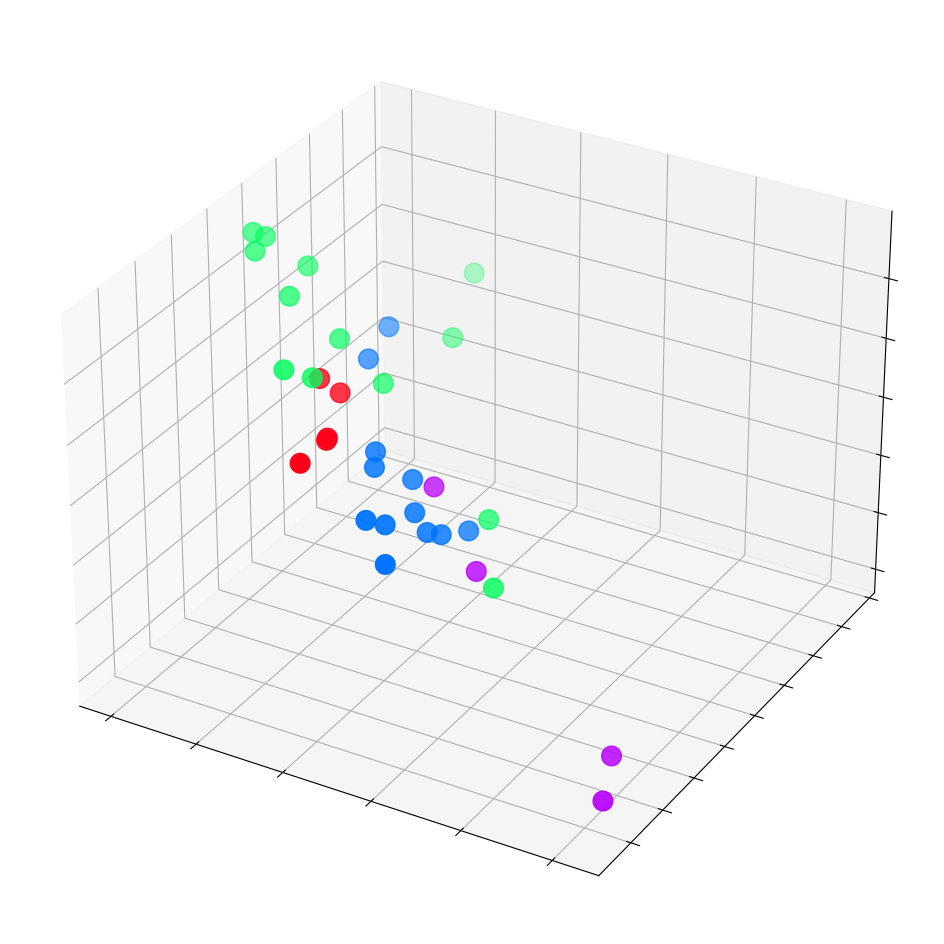

In [179]:
# Get embeddings
_, h = gat(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

In [180]:
# Train
train(gat, data, epochs)

# Test
# acc = test(gcn, data)
# print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   1 | Train Loss: 1.502 | Train Acc:  25.00%
Epoch  11 | Train Loss: 1.260 | Train Acc:  25.00%
Epoch  21 | Train Loss: 1.218 | Train Acc:  25.00%
Epoch  31 | Train Loss: 0.962 | Train Acc:  75.00%
Epoch  41 | Train Loss: 0.650 | Train Acc:  75.00%
Epoch  51 | Train Loss: 0.387 | Train Acc: 100.00%
Epoch  61 | Train Loss: 0.196 | Train Acc: 100.00%
Epoch  71 | Train Loss: 0.111 | Train Acc: 100.00%
Epoch  81 | Train Loss: 0.076 | Train Acc: 100.00%
Epoch  91 | Train Loss: 0.058 | Train Acc: 100.00%
Epoch 101 | Train Loss: 0.047 | Train Acc: 100.00%
Epoch 111 | Train Loss: 0.040 | Train Acc: 100.00%
Epoch 121 | Train Loss: 0.034 | Train Acc: 100.00%
Epoch 131 | Train Loss: 0.030 | Train Acc: 100.00%
Epoch 141 | Train Loss: 0.027 | Train Acc: 100.00%
Epoch 151 | Train Loss: 0.024 | Train Acc: 100.00%
Epoch 161 | Train Loss: 0.022 | Train Acc: 100.00%
Epoch 171 | Train Loss: 0.020 | Train Acc: 100.00%
Epoch 181 | Train Loss: 0.018 | Train Acc: 100.00%
Epoch 191 | Train Loss: 0.017 |

GAT(
  (gat1): GATv2Conv(34, 3, heads=1)
  (gat2): GATv2Conv(3, 3, heads=1)
  (gat3): GATv2Conv(3, 3, heads=1)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)

Embedding shape: [34, 3]


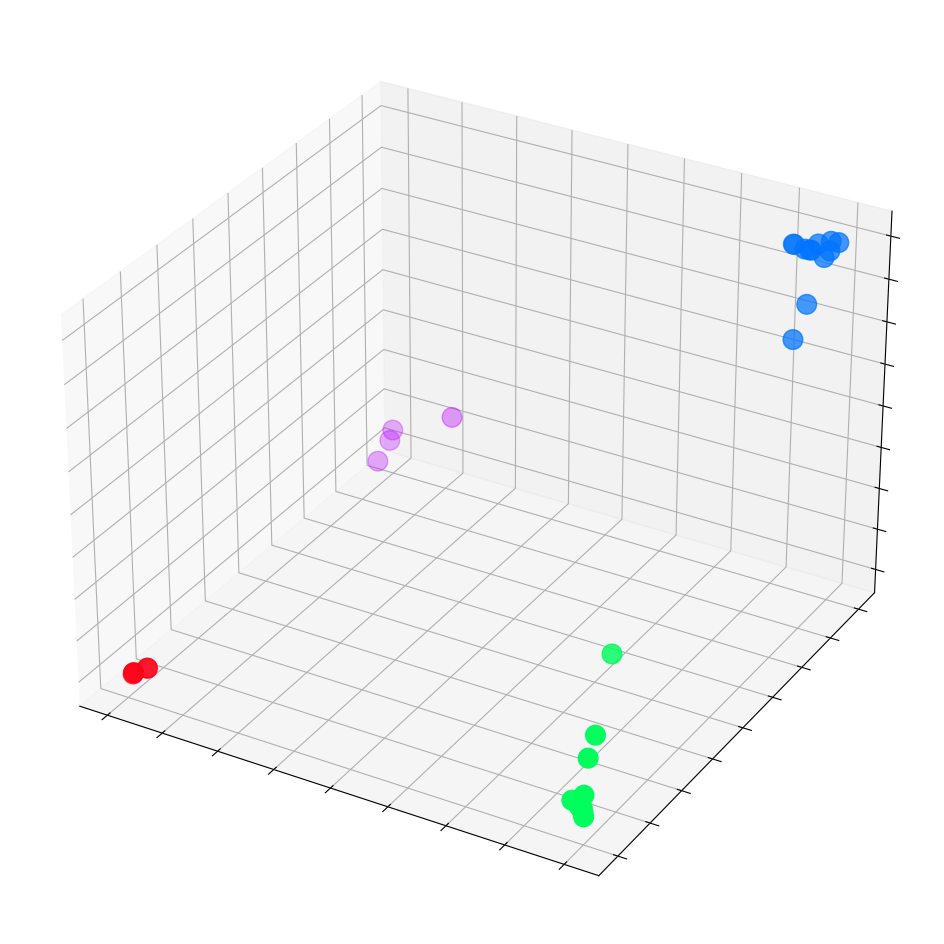

In [181]:
# Get embeddings
_, h = gcn(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

## Graph SAGE

In [186]:
class GraphSAGE(torch.nn.Module):
	"""GraphSAGE"""
	def __init__(self, dim_in, dim_h, dim_out):
		super().__init__()
		self.sage1 = SAGEConv(dim_in, dim_h)
		self.sage2 = SAGEConv(dim_h, dim_h)
		self.sage3 = SAGEConv(dim_h, dim_h)
		self.classifier = Linear(dim_h, dim_out)	
	
	def forward(self, x, edge_index):
		# Node ebeddings
		h = self.sage1(x, edge_index)
		h = h.tanh()
		h = self.sage2(h, edge_index)
		h = h.tanh()
		h = self.sage3(h, edge_index)
		h = h.tanh()  # Final GNN embedding space.
		
		# Apply a final (linear) classifier.
		out = self.classifier(h)

		return out, h

sage = GraphSAGE(dim_in, dim_h, dim_out)
print(sage)

GraphSAGE(
  (sage1): SAGEConv(34, 3, aggr=mean)
  (sage2): SAGEConv(3, 3, aggr=mean)
  (sage3): SAGEConv(3, 3, aggr=mean)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)


Embedding shape: [34, 3]


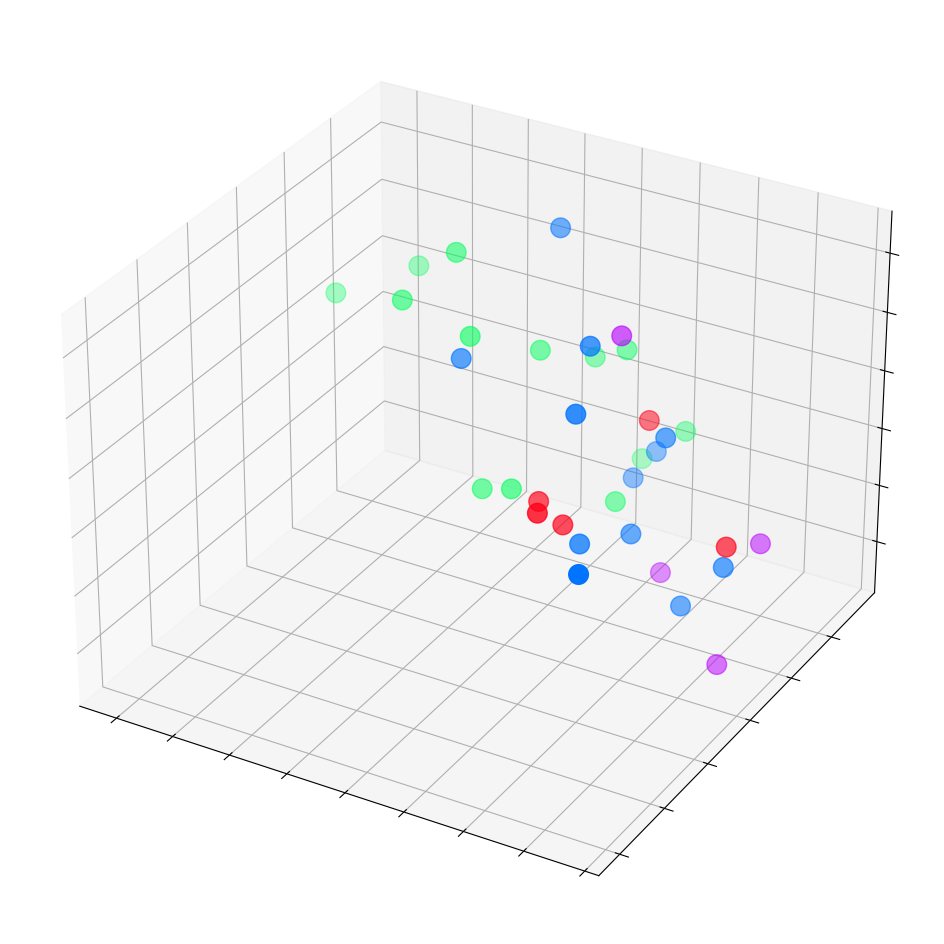

In [187]:
# Get embeddings
_, h = sage(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

In [188]:
# Train
train(sage, data, epochs)

# Test
# acc = test(gcn, data)
# print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   1 | Train Loss: 1.440 | Train Acc:  25.00%
Epoch  11 | Train Loss: 1.113 | Train Acc:  50.00%
Epoch  21 | Train Loss: 0.741 | Train Acc:  50.00%
Epoch  31 | Train Loss: 0.521 | Train Acc:  50.00%
Epoch  41 | Train Loss: 0.361 | Train Acc: 100.00%
Epoch  51 | Train Loss: 0.242 | Train Acc: 100.00%
Epoch  61 | Train Loss: 0.161 | Train Acc: 100.00%
Epoch  71 | Train Loss: 0.113 | Train Acc: 100.00%
Epoch  81 | Train Loss: 0.084 | Train Acc: 100.00%
Epoch  91 | Train Loss: 0.066 | Train Acc: 100.00%
Epoch 101 | Train Loss: 0.053 | Train Acc: 100.00%
Epoch 111 | Train Loss: 0.044 | Train Acc: 100.00%
Epoch 121 | Train Loss: 0.038 | Train Acc: 100.00%
Epoch 131 | Train Loss: 0.033 | Train Acc: 100.00%
Epoch 141 | Train Loss: 0.029 | Train Acc: 100.00%
Epoch 151 | Train Loss: 0.026 | Train Acc: 100.00%
Epoch 161 | Train Loss: 0.024 | Train Acc: 100.00%
Epoch 171 | Train Loss: 0.022 | Train Acc: 100.00%
Epoch 181 | Train Loss: 0.020 | Train Acc: 100.00%
Epoch 191 | Train Loss: 0.018 |

GraphSAGE(
  (sage1): SAGEConv(34, 3, aggr=mean)
  (sage2): SAGEConv(3, 3, aggr=mean)
  (sage3): SAGEConv(3, 3, aggr=mean)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)

Embedding shape: [34, 3]


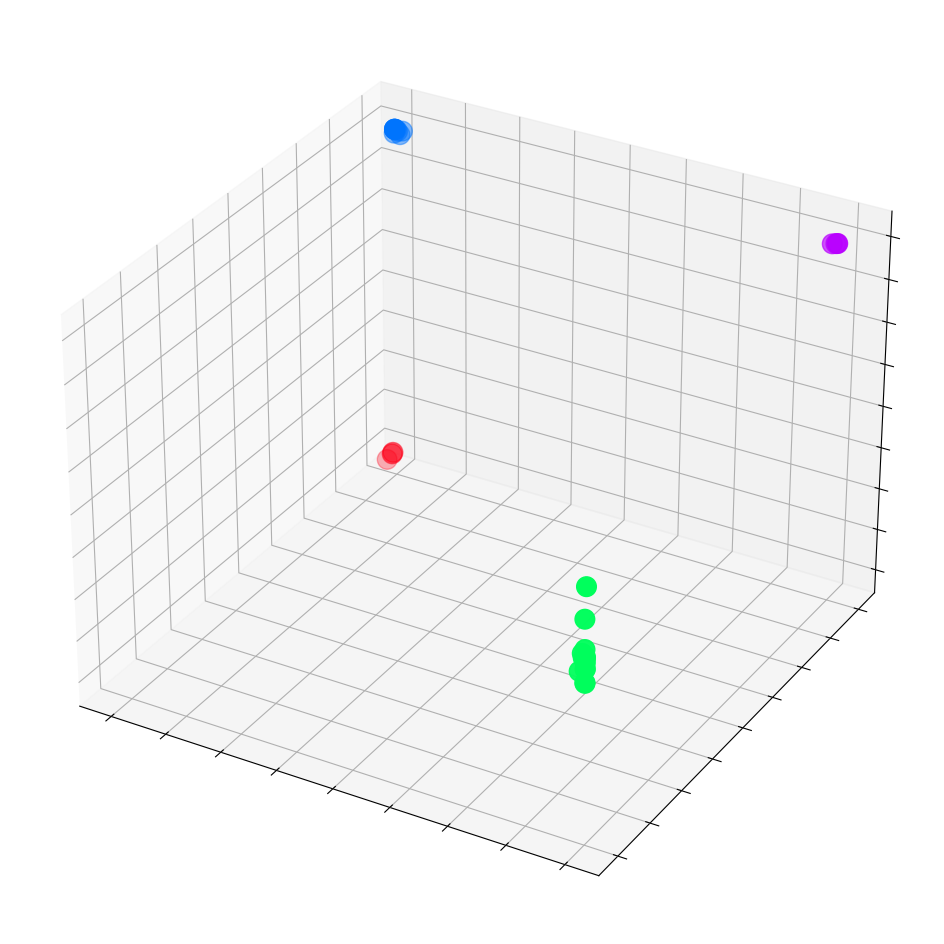

In [189]:
# Get embeddings
_, h = sage(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

## Graph Isomorphism Network (GIN)

In [195]:
class GIN(torch.nn.Module):
	"""GIN"""
	def __init__(self, dim_in, dim_h, dim_out):
		super(GIN, self).__init__()
		self.gin1 = GINConv(Sequential(Linear(dim_in, dim_h), BatchNorm1d(dim_h), 
								ReLU(), Linear(dim_h, dim_h), ReLU()))
		self.gin2 = GINConv(Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), 
								ReLU(), Linear(dim_h, dim_h), ReLU()))
		self.gin3 = GINConv(Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), 
								ReLU(), Linear(dim_h, dim_h), ReLU()))
		self.classifier = Linear(dim_h, dim_out)

	def forward(self, x, edge_index):
		# Node ebeddings
		h = self.gin1(x, edge_index)
		h = h.tanh()
		h = self.gin2(h, edge_index)
		h = h.tanh()
		h = self.gin3(h, edge_index)
		h = h.tanh()  # Final GNN embedding space.
		
		# Apply a final (linear) classifier.
		out = self.classifier(h)

		return out, h

gin = GIN(dataset.num_features, 3, dataset.num_classes)
print(gin)

GIN(
  (gin1): GINConv(nn=Sequential(
    (0): Linear(in_features=34, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): ReLU()
  ))
  (gin2): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): ReLU()
  ))
  (gin3): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): ReLU()
  ))
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)


Embedding shape: [34, 3]


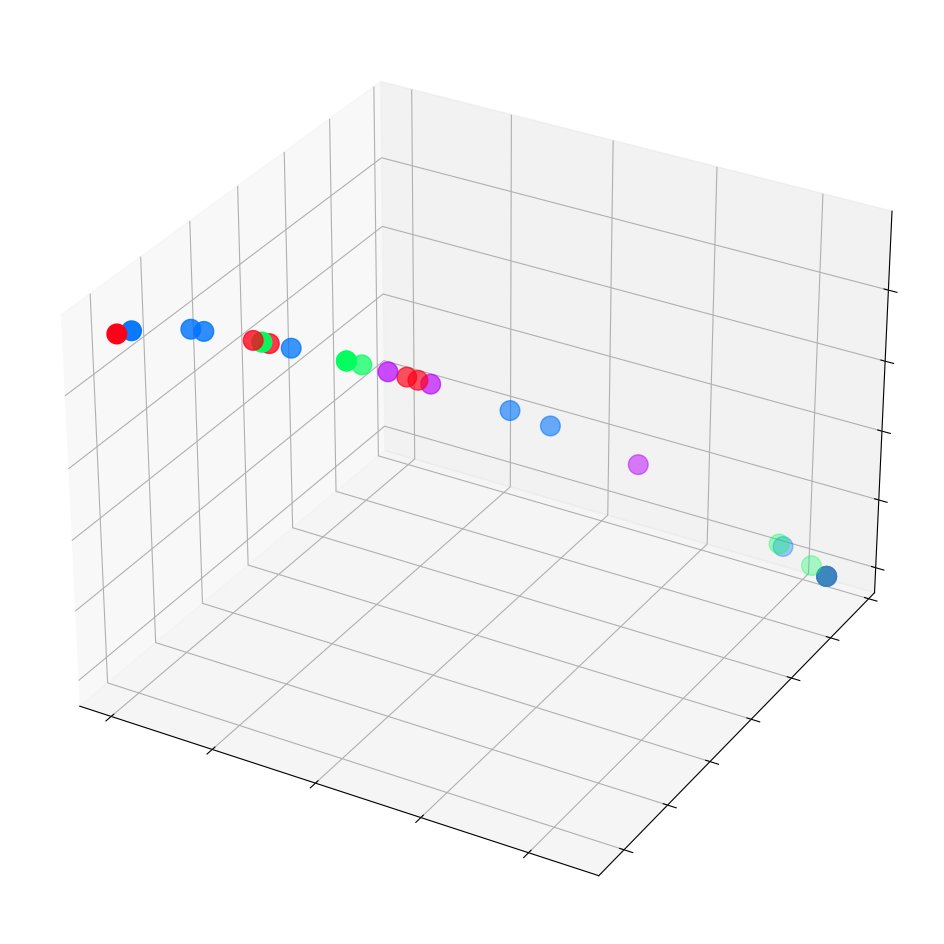

In [196]:
# Get embeddings
_, h = gin(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)

In [197]:
# Train
train(gin, data, epochs)

# Test
# acc = test(gcn, data)
# print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   1 | Train Loss: 1.443 | Train Acc:  25.00%
Epoch  11 | Train Loss: 1.257 | Train Acc:  25.00%
Epoch  21 | Train Loss: 1.174 | Train Acc:  25.00%
Epoch  31 | Train Loss: 1.046 | Train Acc:  25.00%
Epoch  41 | Train Loss: 0.933 | Train Acc:  50.00%
Epoch  51 | Train Loss: 0.800 | Train Acc:  50.00%
Epoch  61 | Train Loss: 0.697 | Train Acc:  50.00%
Epoch  71 | Train Loss: 0.661 | Train Acc:  50.00%
Epoch  81 | Train Loss: 0.624 | Train Acc:  50.00%
Epoch  91 | Train Loss: 0.609 | Train Acc:  50.00%
Epoch 101 | Train Loss: 0.597 | Train Acc:  50.00%
Epoch 111 | Train Loss: 0.588 | Train Acc:  50.00%
Epoch 121 | Train Loss: 0.576 | Train Acc:  50.00%
Epoch 131 | Train Loss: 0.562 | Train Acc:  75.00%
Epoch 141 | Train Loss: 0.552 | Train Acc:  75.00%
Epoch 151 | Train Loss: 0.542 | Train Acc:  75.00%
Epoch 161 | Train Loss: 0.491 | Train Acc:  75.00%
Epoch 171 | Train Loss: 0.418 | Train Acc:  75.00%
Epoch 181 | Train Loss: 0.384 | Train Acc:  75.00%
Epoch 191 | Train Loss: 0.359 |

GIN(
  (gin1): GINConv(nn=Sequential(
    (0): Linear(in_features=34, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): ReLU()
  ))
  (gin2): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): ReLU()
  ))
  (gin3): GINConv(nn=Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): ReLU()
  ))
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)

Embedding shape: [34, 3]


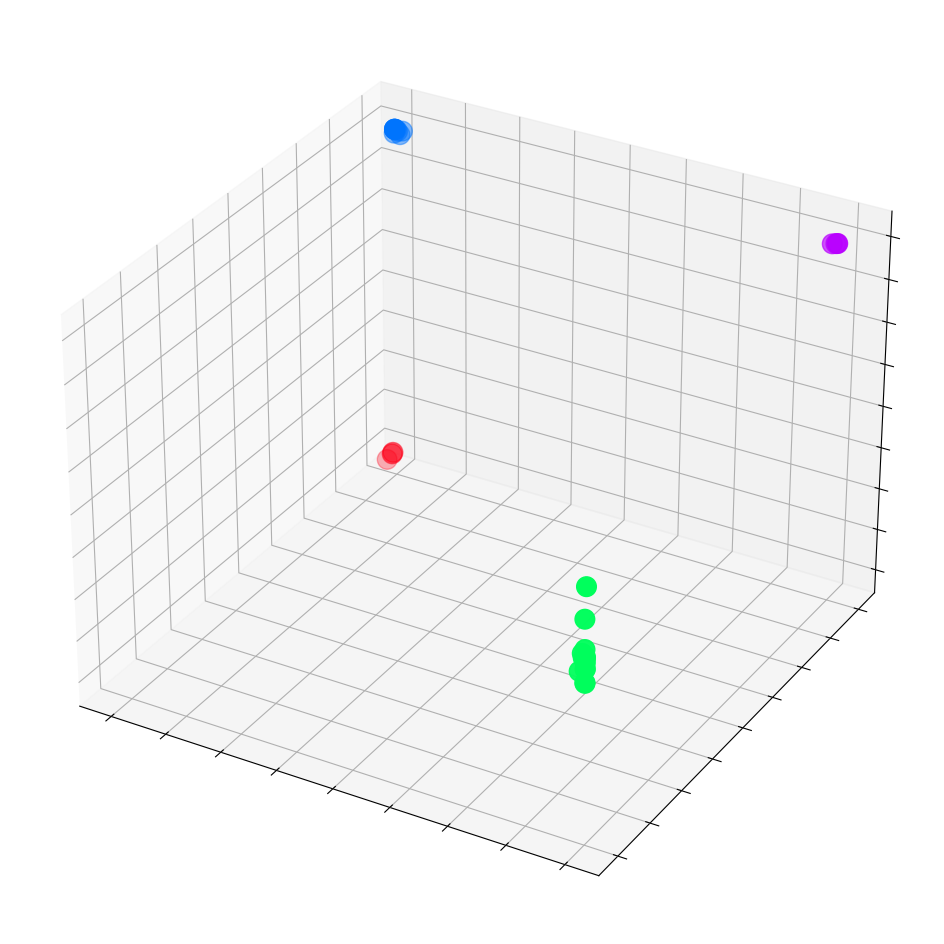

In [198]:
# Get embeddings
_, h = sage(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# visualize(None, h, color=data.y)
plot_embedding_3d(h)